In [2]:
!pip3 install tensorflow

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [4]:
class Predictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [5]:
def prepare_country_data(country_data, sequence_length=5):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(country_data.reshape(-1, 1))
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler


In [7]:
def train_model(X, y, epochs=200):
    # Create dataset and dataloader
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Initialize model
    model = Predictor(input_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    return model

In [8]:
def predict_future(model, last_sequence, scaler, n_future=5):
    model.eval()
    current_sequence = last_sequence.copy()
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_future):
            sequence = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(sequence)
            predictions.append(pred.numpy())
            current_sequence = np.vstack((current_sequence[1:], pred.numpy()))
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()


In [15]:
df = pd.read_csv('../datasets/Gini.csv')
df.replace("..", pd.NA, inplace=True)
# Forward fill first, then backward fill to handle any remaining NAs at the start
df.rename(columns={'Entity': 'Country'}, inplace=True)
df = df.ffill().bfill()
df.head()

,Country,Code,Gini coefficient 1990,Gini coefficient 1991,Gini coefficient 1992,Gini coefficient 1993,Gini coefficient 1994,Gini coefficient 1995,Gini coefficient 1996,Gini coefficient 1997,...,Gini coefficient 2014,Gini coefficient 2015,Gini coefficient 2016,Gini coefficient 2017,Gini coefficient 2018,Gini coefficient 2019,Gini coefficient 2020,Gini coefficient 2021,Gini coefficient 2022,Gini coefficient 2023
0,Albania,ALB,0.270103,0.270103,0.270103,0.270103,0.270103,0.270103,0.270103,0.270103,...,0.345989,0.327537,0.337363,0.330557,0.301483,0.301158,0.294196,0.294196,0.294196,0.294196
1,Algeria,DZA,0.353301,0.353301,0.353301,0.353301,0.353301,0.353301,0.353301,0.353301,...,0.276157,0.276157,0.276157,0.276157,0.276157,0.276157,0.276157,0.276157,0.276157,0.276157
2,Angola,AGO,0.519447,0.519447,0.519447,0.519447,0.519447,0.519447,0.519447,0.519447,...,0.427155,0.427155,0.427155,0.427155,0.512640,0.512640,0.512640,0.512640,0.512640,0.512640
3,Argentina (urban),AGO,0.467545,0.467545,0.454552,0.448434,0.458985,0.488787,0.494914,0.490859,...,0.418225,0.418225,0.423450,0.414348,0.417190,0.433142,0.427438,0.424456,0.407365,0.407365
4,Armenia,ARM,0.362197,0.362197,0.362197,0.362197,0.362197,0.362197,0.362197,0.362197,...,0.314833,0.323568,0.325479,0.336218,0.344335,0.300312,0.251316,0.279401,0.279453,0.279453


In [16]:
gdp_cols = [col for col in df.columns if 'Gini coefficient' in col]
    
sequence_length = 5
predictions_by_country = {}
selected_countries = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom']

In [17]:
for country in df['Country']:
        print(f"\nTraining model for {country}")
        
        # Get country data
        country_data = df[df['Country'] == country][gdp_cols].values.flatten()

        country_data = country_data.astype(float)
        
        # Prepare data
        X, y, scaler = prepare_country_data(country_data, sequence_length)
        
        if len(X) > 0:  # Check if we have enough data
            # Train model
            model = train_model(X, y)
            
            # Make predictions
            last_sequence = scaler.transform(country_data[-sequence_length:].reshape(-1, 1))
            predictions = predict_future(model, last_sequence, scaler)
            predictions_by_country[country] = predictions
    


Training model for Albania
Epoch [50/200], Loss: 0.0543
Epoch [100/200], Loss: 0.0363
Epoch [150/200], Loss: 0.0321
Epoch [200/200], Loss: 0.0316

Training model for Algeria
Epoch [50/200], Loss: 0.0532
Epoch [100/200], Loss: 0.0628
Epoch [150/200], Loss: 0.0341
Epoch [200/200], Loss: 0.0331

Training model for Angola
Epoch [50/200], Loss: 0.1158
Epoch [100/200], Loss: 0.0706
Epoch [150/200], Loss: 0.0575
Epoch [200/200], Loss: 0.0537

Training model for Argentina (urban)
Epoch [50/200], Loss: 0.0314
Epoch [100/200], Loss: 0.0123
Epoch [150/200], Loss: 0.0144
Epoch [200/200], Loss: 0.0081

Training model for Armenia
Epoch [50/200], Loss: 0.0445
Epoch [100/200], Loss: 0.0342
Epoch [150/200], Loss: 0.0285
Epoch [200/200], Loss: 0.0265

Training model for Australia
Epoch [50/200], Loss: 0.0534
Epoch [100/200], Loss: 0.0403
Epoch [150/200], Loss: 0.0307
Epoch [200/200], Loss: 0.0272

Training model for Austria
Epoch [50/200], Loss: 0.0696
Epoch [100/200], Loss: 0.0688
Epoch [150/200], Los

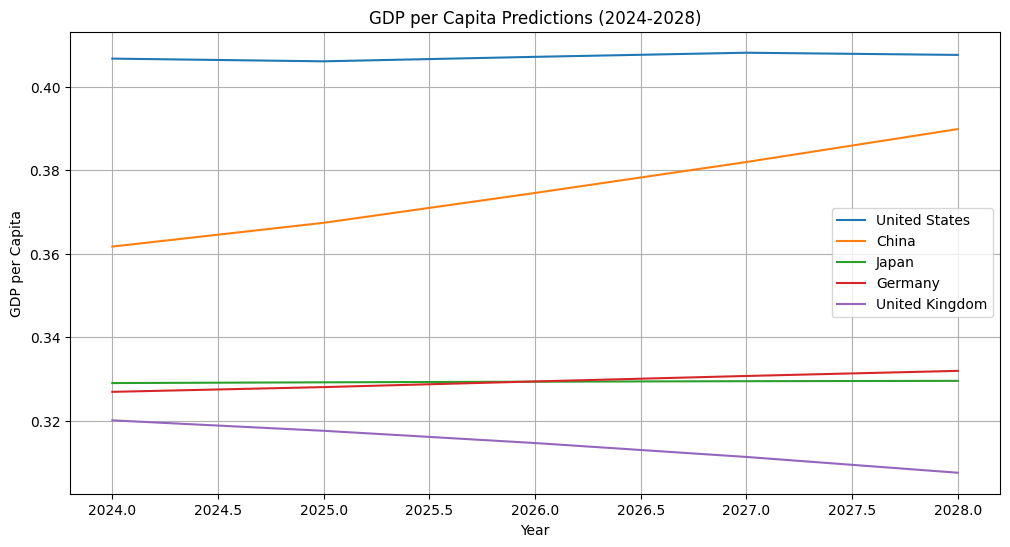


Predicted GDP per Capita (2024-2028):

United States:
2024: $0.41
2025: $0.41
2026: $0.41
2027: $0.41
2028: $0.41

China:
2024: $0.36
2025: $0.37
2026: $0.37
2027: $0.38
2028: $0.39

Japan:
2024: $0.33
2025: $0.33
2026: $0.33
2027: $0.33
2028: $0.33

Germany:
2024: $0.33
2025: $0.33
2026: $0.33
2027: $0.33
2028: $0.33

United Kingdom:
2024: $0.32
2025: $0.32
2026: $0.31
2027: $0.31
2028: $0.31


In [18]:
plt.figure(figsize=(12, 6))
for country in selected_countries:
    if country in predictions_by_country:
        plt.plot(range(2024, 2029), predictions_by_country[country], label=country)
plt.title('GDP per Capita Predictions (2024-2028)')
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.legend()
plt.grid(True)
plt.show()
    
    # Print predictions for selected countries
print("\nPredicted GDP per Capita (2024-2028):")
for country in selected_countries:
    if country in predictions_by_country:
        print(f"\n{country}:")
        for year, pred in zip(range(2024, 2029), predictions_by_country[country]):
            print(f"{year}: ${pred:,.2f}")

In [20]:
# Export predictions to CSV
predictions_df = pd.DataFrame()
predictions_df['Country'] = list(predictions_by_country.keys())

for year in range(2024, 2029):
    year_predictions = []
    for country in predictions_df['Country']:
        if country in predictions_by_country:
            year_predictions.append(predictions_by_country[country][year-2024])
        else:
            year_predictions.append(None)
    predictions_df[f'{year} Gini'] = year_predictions

predictions_df.to_csv('../lstm_datasets/gini_prediction.csv', index=False)
print("\nPredictions exported to lstm_datasets/gini_prediction.csv")



Predictions exported to lstm_datasets/gini_prediction.csv
